Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [63]:
import logging
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
import random

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

In [64]:
def rastrigin(x, A=10):
    """NumPy Rastrigin test function"""
    return -np.sum(A - A * np.cos(2 * np.pi * x) + x**2, axis=0)

def sphere(x):
    return -np.sum(x**2, axis = 0)

In [65]:
np.random.seed(42)
N_DIM = 2

## Evolutionary Strategies

In [66]:
def draw_solutions(solutions, sol, show=False):
    N_POINTS = 200
    r = np.linspace(-5, 5, N_POINTS)
    x = np.array(np.meshgrid(r, r))
    z = rastrigin(x)
    # z = sphere(x)
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection="3d")
    ax.plot_surface(*np.meshgrid(r, r), z, rstride=1, cstride=1, cmap=cm.plasma, alpha=0.1, linewidth=0, antialiased=False)
    for solution in solutions:
        ax.scatter(solution[0], solution[1], rastrigin(solution), s=10, color='k', alpha = 0.1)
    if show:
        # Show the path to the founded solution
        z = np.array([rastrigin(np.array([solutions[i, 0], solutions[i, 1]])) for i in range(solutions.shape[0])])
        ax.plot(solutions[:, 0], solutions[:, 1], z, color='k', alpha=0.3)
    ax.scatter(sol[0], sol[1], rastrigin(sol), s=30,alpha=0.5, color='r')
    ax.scatter(0, 0, rastrigin(np.array([0, 0])), s=30,alpha=0.5, color='b')

In [67]:
def evaluate(sol):
    return rastrigin(sol)

def solve(mut_rate = 1):
    # Strating from this, mutate until convergence.
    unuseful_step = 0
    sol = np.random.uniform(-5, 5, 2)
    solutions = [sol]
    iteration = 0
    while unuseful_step < 100000:
        unuseful_step += 1
        new_sol = np.array([sol[0] + np.random.normal(0, mut_rate), sol[1] + np.random.normal(0, mut_rate)])
        if evaluate(new_sol) > evaluate(sol):
            logging.debug(f"Found a new solution {new_sol}")
            iteration += 1
            sol = new_sol
            solutions.append(sol)
            unuseful_step = 0
        else: 
            unuseful_step += 1
    logging.debug(f"Result: {sol}, found in {iteration} iteration")
    return solutions, sol

[16:37:20] DEBUG: Found a new solution [-1.95705894  3.80473219]
[16:37:20] DEBUG: Found a new solution [-1.23117212 -1.93510854]
[16:37:20] DEBUG: Found a new solution [1.86182645 0.85873182]
[16:37:20] DEBUG: Found a new solution [ 2.12296765 -0.03829023]
[16:37:20] DEBUG: Found a new solution [ 0.01680837 -1.02127667]
[16:37:20] DEBUG: Found a new solution [0.07211017 0.02146844]
[16:37:20] DEBUG: Found a new solution [ 0.07273136 -0.00643252]
[16:37:20] DEBUG: Found a new solution [ 0.00613069 -0.05307398]
[16:37:20] DEBUG: Found a new solution [0.0085947  0.03447729]
[16:37:21] DEBUG: Found a new solution [ 0.00321806 -0.00175219]
[16:37:22] DEBUG: Result: [ 0.00321806 -0.00175219], found in 10 iteration


(11, 2)
Found a solution in [ 0.00321806 -0.00175219], d_z = 0.0026635477173820163, d_s = [ 0.00321806 -0.00175219]


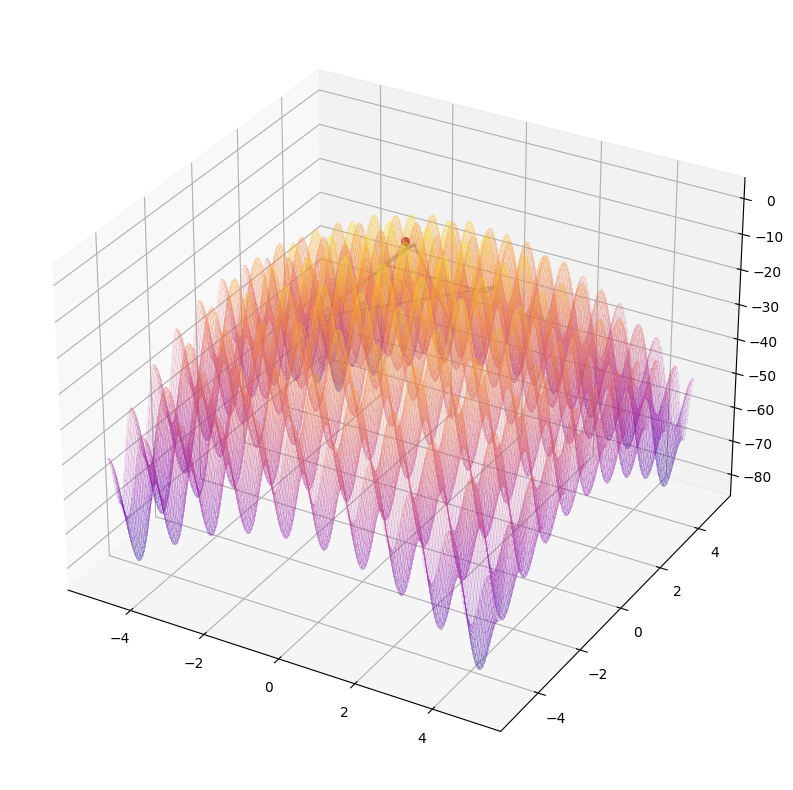

In [68]:
# Solve rastrigin with (1 + 1)
logging.getLogger().setLevel(logging.DEBUG)
solutions, sol = solve(3)
solutions = np.array(solutions)
print(solutions.shape)
print(f"Found a solution in {sol}, d_z = {abs(rastrigin(sol) - rastrigin(np.array([0, 0])))}, d_s = {sol - np.array([0, 0])}")
draw_solutions(np.array(solutions), sol, show=True)


### (1 + $\lambda$) ES


In [69]:
def tweak(sol, mut_rate):
    return  sol + np.array([np.random.normal(0, mut_rate), np.random.normal(0, mut_rate)])

def solve(l = 10, mut_rate = 1):
    # Strating from this, mutate until convergence.
    unuseful_step = 0
    sol = np.random.uniform(-5, 5, 2)
    solutions = [sol]
    iteration = 0
    while unuseful_step < 1000:
        mutations = [tweak(sol, mut_rate=mut_rate) for _ in range(l)]
        for mut in mutations:
            if evaluate(mut) > evaluate(sol):
                sol = mut
                unuseful_step = 0
                solutions.append(sol)
        unuseful_step += 1
        iteration += 1
    logging.debug(f"Result: {sol}, found in {iteration} iteration")
    return solutions, sol

[16:37:26] DEBUG: Result: [-0.00801202 -0.00802262], found in 1582 iteration


Found a solution in [-0.00801202 -0.00802262], d_z = 0.025498928066446686, d_s = [-0.00801202 -0.00802262]


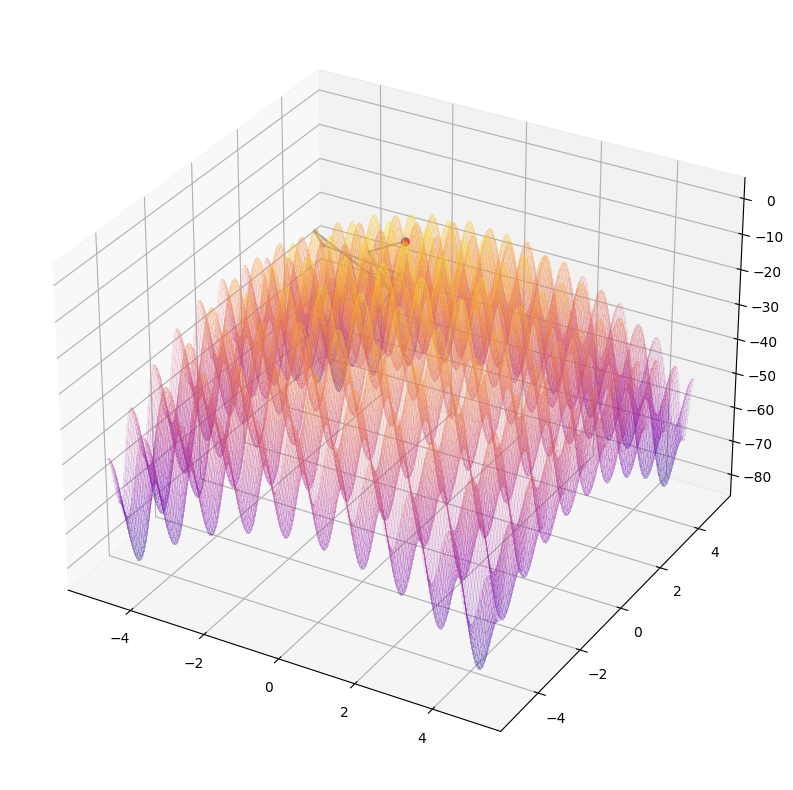

In [70]:
# Solve rastrigin with (1 + lambda)
logging.getLogger().setLevel(logging.DEBUG)
solutions, sol = solve(l=10, mut_rate=3)
solutions = np.array(solutions)
print(f"Found a solution in {sol}, d_z = {abs(rastrigin(sol) - rastrigin(np.array([0, 0])))}, d_s = {sol - np.array([0, 0])}")
draw_solutions(np.array(solutions), sol, show=True)

### (1, $\lambda$) ES

In [76]:
import numpy.linalg as linalg

def solve(l = 10, mut_rate = 1):
    # Strating from this, mutate until convergence.
    unuseful_step = 0
    sol = np.random.uniform(-5, 5, 2)
    prev_sol = np.random.uniform(-5, 5, 2) + np.array([1, 1]) 
    solutions = [sol]
    iteration = 0
    while linalg.norm(rastrigin(sol) - rastrigin(prev_sol)) > 1e-3:
        mutations = sorted([tweak(sol, mut_rate=mut_rate) for _ in range(l)], key=lambda s: -evaluate(s))
        prev_sol = sol
        sol = mutations[0]
        solutions.append(sol)
        iteration += 1
    logging.debug(f"Result: {sol}, found in {iteration} iteration")
    return solutions, sol

[16:42:43] DEBUG: Result: [-0.02365382 -0.02389467], found in 192 iteration


Found a solution in [-0.02365382 -0.02389467], d_z = 0.22385931032953624, d_s = [-0.02365382 -0.02389467]


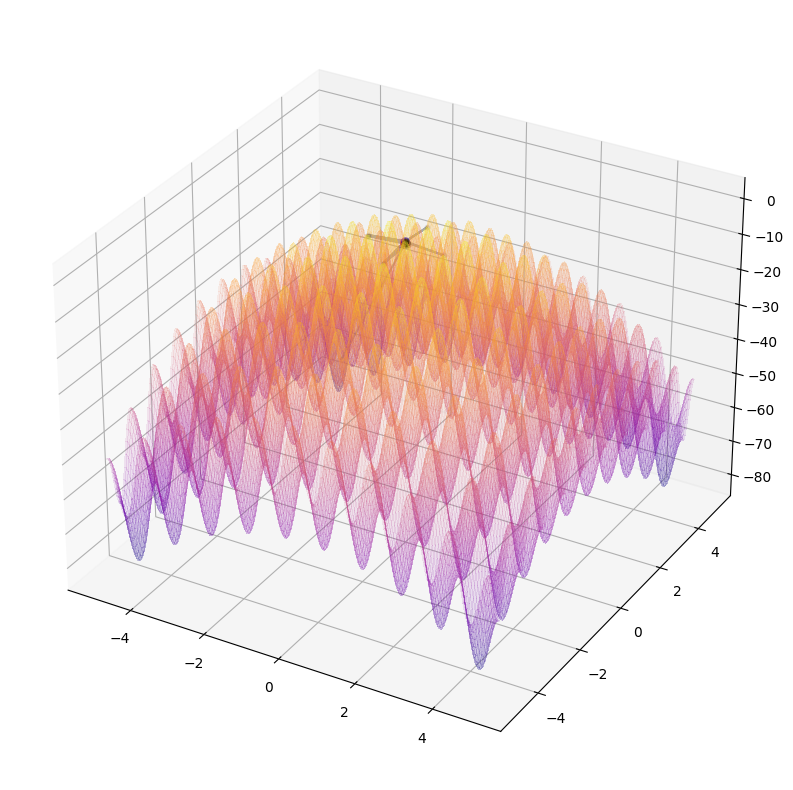

In [77]:
# Solve rastrigin with (1 + lambda)
logging.getLogger().setLevel(logging.DEBUG)
solutions, sol = solve(l=10000, mut_rate=3)
solutions = np.array(solutions)
print(f"Found a solution in {sol}, d_z = {abs(rastrigin(sol) - rastrigin(np.array([0, 0])))}, d_s = {sol - np.array([0, 0])}")
draw_solutions(np.array(solutions), sol, show=True)